# Convolutional neural networks
This notebook uses the `hybridmodels-modelbuild` virtual environment.

In [313]:
from os.path import join
import glob
from itertools import compress

import numpy as np
import pandas as pd
import tensorflow as tf
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# functions to get dimensions to create node feature matrices for grid
def get_rows_and_cols(df, gridsize=500):
    """
    Parameters:
    -----------
    gridsize : float
        length of one side of a square gridcell in grid.
    """
    from shapely.geometry import box
    df_pm = df.to_crs("EPSG:3857")
    bbounds = df_pm.total_bounds
    width = bbounds[2] - bbounds[0]
    height = bbounds[3] - bbounds[1]
    nrows = int(np.round(height / gridsize, 0))
    ncols = int(np.round(width  / gridsize, 0))
    return nrows, ncols

def reshape_df(df, nrows, ncols, features):
    df = df.drop("geometry", axis=1)
    feature_mat = np.empty(shape=(nrows, ncols, len(features)), dtype="float")
    for i, feature in enumerate(features):
        feature_arr = df[feature].values.reshape(nrows, ncols, order="F")
        feature_mat[:, :, i] = feature_arr
    return feature_mat

## Load and parse data

In [327]:
# load the data
wd = join("..", "data", "indata_new")
features = ['gebco', 'fabdem', 'jrc_permwa', 'precip', 'soilcarbon', 'mangrove', 'ndvi', 'wind_avg']
columns = features + ['storm', 'region', 'subregion', "geometry", "floodfrac"]

# separate files based on staggering level
files = [filename for filename in glob.glob(join(wd, "feature_stats", "*.shp"))]
orig_mask = [True if filename.split('.')[-2][-2:] == '_0' else False for filename in files]
plus_mask = [True if filename.split('.')[-2][-4:] == '_250' else False for filename in files]
minus_mask = [True if filename.split('.')[-2][-4:] == '-250' else False for filename in files]
orig = list(compress(files, orig_mask))
plus = list(compress(files, plus_mask))
minus = list(compress(files, minus_mask))

# format event columns
def format_gdf(gdf, filelist):
    l = [gpd.read_file(filename) for filename in filelist]
    gdf = pd.concat(l, axis=0)
    gdf = gdf[columns]
    gdf["event"] = gdf["storm"] + "_" + gdf["region"] + "_" + gdf["subregion"].astype(str)
    gdf = gdf.drop(["storm", "region", "subregion"], axis=1).reset_index(drop=True)
    return gdf

gdf = format_gdf(gdf, orig)
gdf_plus = format_gdf(gdf, plus)
gdf_minus = format_gdf(gdf, minus)


columns.remove("storm")
columns.remove("region")
columns.remove("subregion")

### EDA

<AxesSubplot:>

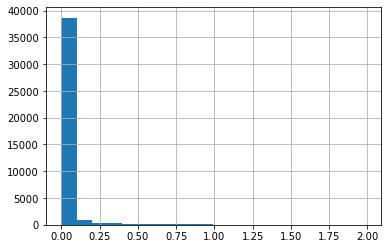

In [316]:
gdf['floodfrac'].hist(bins=20)

In [317]:
print(f"skew: {gdf['floodfrac'].skew()}")
print(f"kurtosis: {gdf['floodfrac'].kurtosis()}")
gdf['floodfrac'].describe()

skew: 7.66909689410825
kurtosis: 76.58341812483111


count    40960.000000
mean         0.022714
std          0.109776
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.988365
Name: floodfrac, dtype: float64

### Format training set
- [ ] random horizontal / vertical flips
- [ ] better viz

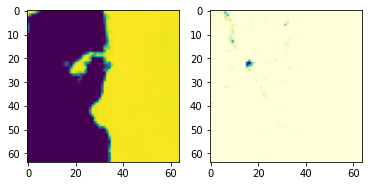

In [481]:
events = [*gdf['event'].unique()]

event = events[5]
temp = gdf[gdf.event==str(event)]
nrows, ncols = get_rows_and_cols(temp, gridsize=500)
X = reshape_df(temp, nrows, ncols, features)
y = reshape_df(temp, nrows, ncols, ["floodfrac"])

# clip to size
X = X[:64, :64, :]
y = y[:64, :64, 0]

a, b, c = X.shape
Xmat = np.zeros((64, 64, c), dtype=float)
ymat = np.zeros((64, 64), dtype=float)
Xmat[:a, :b, :] = X
ymat[:a, :b] = y

fig, ax = plt.subplots(1, 2)
ax[0].imshow(Xmat[:, :, 2])
ax[1].imshow(ymat, cmap="YlGnBu")

In [505]:
Xmats = []
ymats = []

for event in [*gdf['event'].unique()]:
    temp = gdf[gdf.event==str(event)]
    nrows, ncols = get_rows_and_cols(temp, gridsize=500)
    X = reshape_df(temp, nrows, ncols, features)
    y = reshape_df(temp, nrows, ncols, ["floodfrac"])
    
    # clip to size
    X = X[:64, :64, :]
    y = y[:64, :64, 0]
    
    a, b, c = X.shape
    Xmat = np.zeros((64, 64, c), dtype=float)
    ymat = np.zeros((64, 64), dtype=float)
    Xmat[:a, :b, :] = X
    ymat[:a, :b] = y

    Xmats.append(Xmat)
    ymats.append(ymat)
    
for event in [*gdf_plus['event'].unique()]:
    temp = gdf_plus[gdf_plus.event==str(event)]
    if len(temp) > 0:
        nrows, ncols = get_rows_and_cols(temp, gridsize=500)
        X = reshape_df(temp, nrows, ncols, features)
        y = reshape_df(temp, nrows, ncols, ["floodfrac"])

        # clip to size
        X = X[:64, :64, :]
        y = y[:64, :64, 0]

        a, b, c = X.shape
        Xmat = np.zeros((64, 64, c), dtype=float)
        ymat = np.zeros((64, 64), dtype=float)
        Xmat[:a, :b, :] = X
        ymat[:a, :b] = y

        Xmats.append(Xmat)
        ymats.append(ymat)
        
for event in [*gdf_minus['event'].unique()]:
    if len(temp) > 0:
        temp = gdf_minus[gdf_minus.event==str(event)]
        nrows, ncols = get_rows_and_cols(temp, gridsize=500)
        X = reshape_df(temp, nrows, ncols, features)
        y = reshape_df(temp, nrows, ncols, ["floodfrac"])

        # clip to size
        X = X[:64, :64, :]
        y = y[:64, :64, 0]

        a, b, c = X.shape
        Xmat = np.zeros((64, 64, c), dtype=float)
        ymat = np.zeros((64, 64), dtype=float)
        Xmat[:a, :b, :] = X
        ymat[:a, :b] = y

        Xmats.append(Xmat)
        ymats.append(ymat)

In [506]:
# create tensorflow datasets with batch size 1
n = len(Xmats)
ntrain = int(0.8 * n)
ntest = int(0.1 * n)

# NOTE: shuffling seems to confuse (X, y) pairs and there is no need to shuffle anyway
data = tf.data.Dataset.from_tensor_slices((Xmats, ymats)).batch(1)
train = data.take(ntrain)
test = data.skip(ntrain)
valid = test.skip(ntest)
test = test.take(ntest)

X_train = [element[0].numpy()[0, :, :, :] for element in train]
y_train = [element[1].numpy()[0, :, :] for element in train]
X_valid = [element[0].numpy()[0, :, :, :] for element in valid]
y_valid = [element[1].numpy()[0, :, :] for element in valid]
X_test = [element[0].numpy()[0, :, :, :] for element in test]
y_test = [element[1].numpy()[0, :, :] for element in test]

print("Training size:", len(X_train))
print("Validation size:", len(X_valid))
print("Test size:", len(X_test))

Training size: 20
Validation size: 4
Test size: 2


### View training set

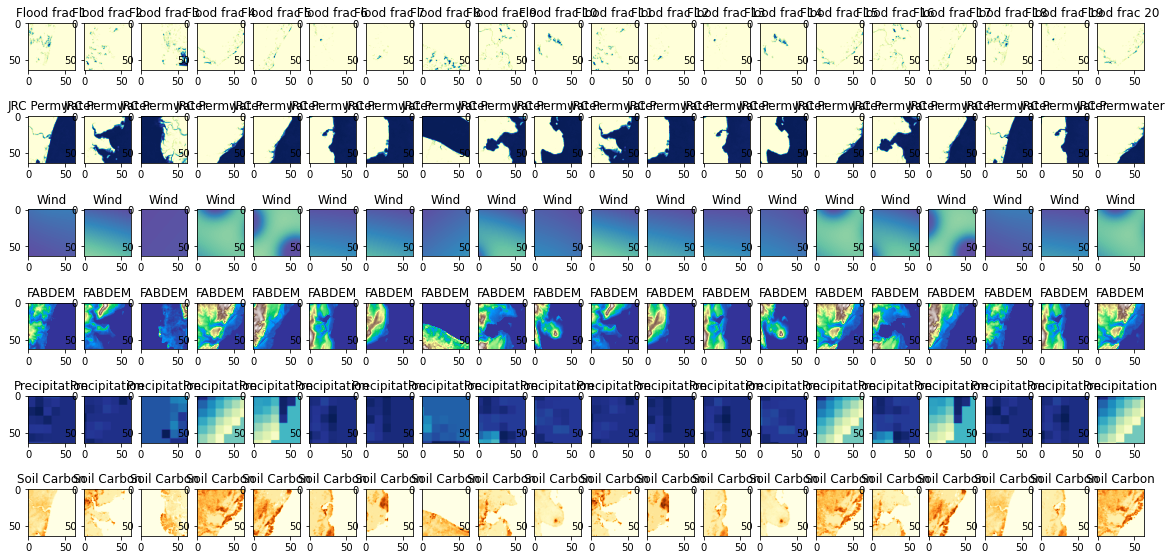

In [507]:
fig, ax = plt.subplots(6, len(y_train), figsize=(20, 10))

for i, im in enumerate(y_train):
    pos = ax[0, i].imshow(im, cmap="YlGnBu")
    ax[0, i].set_title(f"Flood frac {i+1}")
    
for i, im in enumerate(X_train):
    pos = ax[1, i].imshow(im[:, :, 2], cmap="YlGnBu")
    ax[1, i].set_title("JRC Permwater")

for i, im in enumerate(X_train):
    pos = ax[3, i].imshow(im[:, :, 0], cmap="terrain", vmin=0)
    ax[3, i].set_title("FABDEM")

for i, im in enumerate(X_train):
    pos = ax[2, i].imshow(im[:, :, 7], cmap="Spectral_r", vmax=10)
    ax[2, i].set_title("Wind")
    
for i, im in enumerate(X_train):
    pos = ax[4, i].imshow(im[:, :, 3], cmap="YlGnBu", vmin=0)
    ax[4, i].set_title("Precipitation")
    
for i, im in enumerate(X_train):
    pos = ax[5, i].imshow(im[:, :, 4], cmap="YlOrBr", vmin=0)
    ax[5, i].set_title("Soil Carbon")

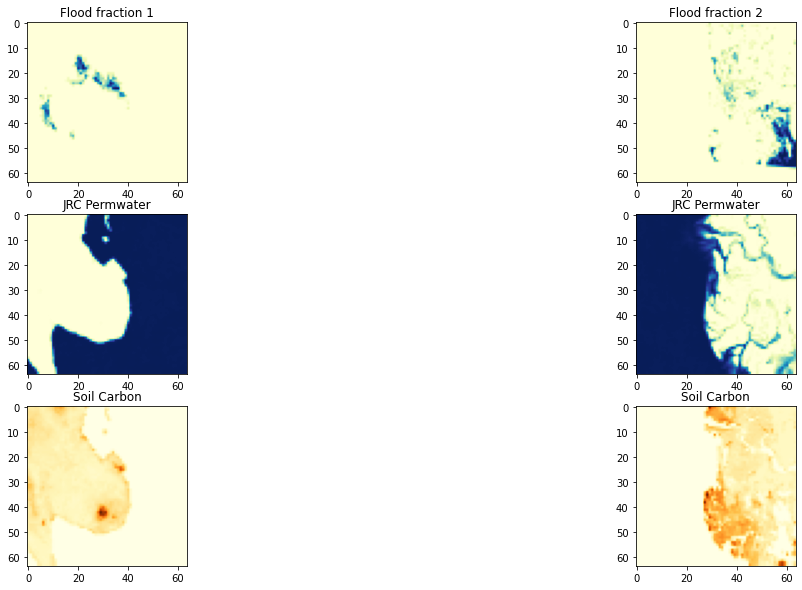

In [508]:
fig, ax = plt.subplots(3, len(y_test), figsize=(20, 10))
for i, im in enumerate(y_test):
    pos = ax[0, i].imshow(im, cmap="YlGnBu")
    ax[0, i].set_title(f"Flood fraction {i+1}")
    
for i, im in enumerate(X_test):
    pos = ax[1, i].imshow(im[:, :, 2], cmap="YlGnBu")
    ax[1, i].set_title("JRC Permwater")
    
for i, im in enumerate(X_test):
    pos = ax[2, i].imshow(im[:, :, 4], cmap="YlOrBr", vmin=0)
    ax[2, i].set_title("Soil Carbon")

Convolutional Neural Networks
[Tutorial here](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/)
### Model hyperparameters
Since the target variable `floodfrac` is very positively-skewed, with many zeros, any Gaussian-assuming loss function such as RMSE can lead to poor results due to zero-inflation. The Tweedie loss function has been developed to deal with this sort of data and is [often used in predicting insurance claims](https://towardsdatascience.com/tweedie-loss-function-for-right-skewed-data-2c5ca470678f). A custom TensorFlow function is provided [here](https://towardsdatascience.com/tweedie-loss-function-for-right-skewed-data-2c5ca470678f). The loss function has the following form,

$$ \mathcal{L} = -\sum_{i} x_i \frac{\hat x_i^{1-p}}{1-p} + \frac{\hat x^{2-p}}{2-p}$$

where $y$ is the trye value, and $\hat y$ is the predicted value. For the optimiser either, stochastic gradient descent with a small (1e-6) learning rate, or else Adam with an adaptive learning rate will be used. Epochs range between 20 and 200 and will need to be explored.
#### Possible future extensions
1. [ ] partialconv padding
2. [ ] dilation to layers

In [509]:
from keras import Sequential
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model

def Tweedie(p):
    def tweedie_loglikelihood(y, y_hat):
        loss = - y * tf.pow(y_hat, 1 - p) / (1 - p) + \
               tf.pow(y_hat, 2 - p) / (2 - p)
        return tf.reduce_mean(loss)
    return tweedie_loglikelihood

def plot_history(history):
    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('root mean squared error')
    plt.plot(history.epoch, np.array(history.history['root_mean_squared_error']), 
           label='train')
    plt.plot(history.epoch, np.array(history.history['val_root_mean_squared_error']),
           label = 'valid')
    plt.legend()
    plt.ylim([0, max(history.history['loss'])])
    
def plot_prediction(test_labels, y_pred, title):
    plt.figure()
    plt.title(title)
    plt.scatter(test_labels, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100],[-100,100])

    plt.figure()
    error = y_pred - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")

#### SCNN Matéo-Garcia (2021)

In [510]:
def build_scnn(shape=(128, 128, 3)):
    inputs = Input(shape=shape)
    normalized = BatchNormalization(axis=3)(inputs)
    x = Conv2D(64, 3, padding="same", activation="relu")(normalized)
    x = Conv2D(128, 3, padding="same", activation="relu")(x)
    x = Conv2D(128, 3, padding="same", activation="relu")(x)
    
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)
    scnn = Model(inputs, outputs, name="SCNN")
    return scnn

In [511]:
scnn = build_scnn(shape=(64, 64, len(gdf[features].columns)))
scnn.summary()

Model: "SCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 64, 64, 8)]       0         
                                                                 
 batch_normalization_30 (Bat  (None, 64, 64, 8)        32        
 chNormalization)                                                
                                                                 
 conv2d_480 (Conv2D)         (None, 64, 64, 64)        4672      
                                                                 
 conv2d_481 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_482 (Conv2D)         (None, 64, 64, 128)       147584    
                                                                 
 conv2d_483 (Conv2D)         (None, 64, 64, 1)         129       
                                                              

In [518]:
scnn.compile(optimizer=SGD(learning_rate=1e-6), loss=Tweedie(1.5), metrics="RootMeanSquaredError")
history = scnn.fit(train, epochs=40, validation_data=valid, callbacks=EarlyStopping(patience=3))

!say done

Epoch 1/200
20/20 [==============================] - 1s 46ms/step - loss: 1.4687 - root_mean_squared_error: 0.4910 - val_loss: 1.3730 - val_root_mean_squared_error: 0.4371
Epoch 2/200
20/20 [==============================] - 1s 43ms/step - loss: 1.4687 - root_mean_squared_error: 0.4909 - val_loss: 1.3729 - val_root_mean_squared_error: 0.4371
Epoch 3/200
20/20 [==============================] - 1s 43ms/step - loss: 1.4687 - root_mean_squared_error: 0.4909 - val_loss: 1.3729 - val_root_mean_squared_error: 0.4370
Epoch 4/200
20/20 [==============================] - 1s 46ms/step - loss: 1.4686 - root_mean_squared_error: 0.4909 - val_loss: 1.3728 - val_root_mean_squared_error: 0.4370
Epoch 5/200
20/20 [==============================] - 1s 41ms/step - loss: 1.4686 - root_mean_squared_error: 0.4908 - val_loss: 1.3727 - val_root_mean_squared_error: 0.4369
Epoch 6/200
20/20 [==============================] - 1s 39ms/step - loss: 1.4685 - root_mean_squared_error: 0.4908 - val_loss: 1.3726 - val_

20/20 [==============================] - 1s 44ms/step - loss: 1.4665 - root_mean_squared_error: 0.4894 - val_loss: 1.3699 - val_root_mean_squared_error: 0.4351
Epoch 49/200
20/20 [==============================] - 1s 42ms/step - loss: 1.4665 - root_mean_squared_error: 0.4893 - val_loss: 1.3699 - val_root_mean_squared_error: 0.4351
Epoch 50/200
20/20 [==============================] - 1s 44ms/step - loss: 1.4664 - root_mean_squared_error: 0.4893 - val_loss: 1.3698 - val_root_mean_squared_error: 0.4351
Epoch 51/200
20/20 [==============================] - 1s 46ms/step - loss: 1.4664 - root_mean_squared_error: 0.4893 - val_loss: 1.3697 - val_root_mean_squared_error: 0.4350
Epoch 52/200
20/20 [==============================] - 1s 44ms/step - loss: 1.4663 - root_mean_squared_error: 0.4892 - val_loss: 1.3697 - val_root_mean_squared_error: 0.4350
Epoch 53/200
20/20 [==============================] - 1s 44ms/step - loss: 1.4663 - root_mean_squared_error: 0.4892 - val_loss: 1.3696 - val_root_me

20/20 [==============================] - 1s 40ms/step - loss: 1.4643 - root_mean_squared_error: 0.4878 - val_loss: 1.3669 - val_root_mean_squared_error: 0.4333
Epoch 96/200
20/20 [==============================] - 1s 39ms/step - loss: 1.4643 - root_mean_squared_error: 0.4877 - val_loss: 1.3669 - val_root_mean_squared_error: 0.4332
Epoch 97/200
20/20 [==============================] - 1s 40ms/step - loss: 1.4642 - root_mean_squared_error: 0.4877 - val_loss: 1.3668 - val_root_mean_squared_error: 0.4332
Epoch 98/200
20/20 [==============================] - 1s 40ms/step - loss: 1.4642 - root_mean_squared_error: 0.4877 - val_loss: 1.3667 - val_root_mean_squared_error: 0.4331
Epoch 99/200
20/20 [==============================] - 1s 40ms/step - loss: 1.4641 - root_mean_squared_error: 0.4876 - val_loss: 1.3667 - val_root_mean_squared_error: 0.4331
Epoch 100/200
20/20 [==============================] - 1s 39ms/step - loss: 1.4641 - root_mean_squared_error: 0.4876 - val_loss: 1.3666 - val_root_m

20/20 [==============================] - 1s 43ms/step - loss: 1.4621 - root_mean_squared_error: 0.4862 - val_loss: 1.3639 - val_root_mean_squared_error: 0.4314
Epoch 143/200
20/20 [==============================] - 1s 42ms/step - loss: 1.4620 - root_mean_squared_error: 0.4861 - val_loss: 1.3638 - val_root_mean_squared_error: 0.4313
Epoch 144/200
20/20 [==============================] - 1s 40ms/step - loss: 1.4620 - root_mean_squared_error: 0.4861 - val_loss: 1.3638 - val_root_mean_squared_error: 0.4313
Epoch 145/200
20/20 [==============================] - 1s 41ms/step - loss: 1.4619 - root_mean_squared_error: 0.4861 - val_loss: 1.3637 - val_root_mean_squared_error: 0.4313
Epoch 146/200
20/20 [==============================] - 1s 40ms/step - loss: 1.4619 - root_mean_squared_error: 0.4860 - val_loss: 1.3637 - val_root_mean_squared_error: 0.4312
Epoch 147/200
20/20 [==============================] - 1s 41ms/step - loss: 1.4618 - root_mean_squared_error: 0.4860 - val_loss: 1.3636 - val_ro

20/20 [==============================] - 1s 40ms/step - loss: 1.4598 - root_mean_squared_error: 0.4846 - val_loss: 1.3609 - val_root_mean_squared_error: 0.4295
Epoch 190/200
20/20 [==============================] - 1s 41ms/step - loss: 1.4598 - root_mean_squared_error: 0.4845 - val_loss: 1.3608 - val_root_mean_squared_error: 0.4295
Epoch 191/200
20/20 [==============================] - 1s 41ms/step - loss: 1.4598 - root_mean_squared_error: 0.4845 - val_loss: 1.3608 - val_root_mean_squared_error: 0.4294
Epoch 192/200
20/20 [==============================] - 1s 41ms/step - loss: 1.4597 - root_mean_squared_error: 0.4845 - val_loss: 1.3607 - val_root_mean_squared_error: 0.4294
Epoch 193/200
20/20 [==============================] - 1s 41ms/step - loss: 1.4597 - root_mean_squared_error: 0.4844 - val_loss: 1.3606 - val_root_mean_squared_error: 0.4293
Epoch 194/200
20/20 [==============================] - 1s 41ms/step - loss: 1.4596 - root_mean_squared_error: 0.4844 - val_loss: 1.3606 - val_ro

In [519]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

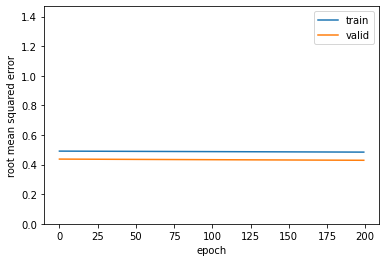

In [520]:
plot_history(history)

Testing set root mean squared error: 0.40


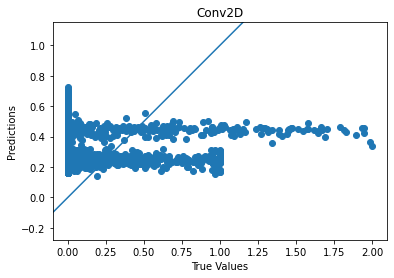

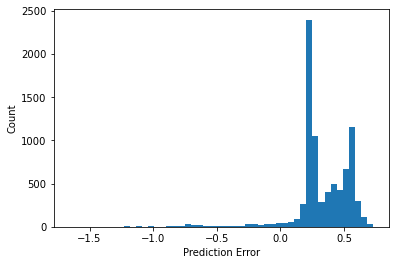

In [521]:
[loss, rmse] = scnn.evaluate(test, verbose=0)
print("Testing set root mean squared error: {:4.2f}".format(rmse))

y_pred = scnn.predict(test)
plot_prediction(np.array(y_test).flatten(), y_pred.flatten(), "Conv2D")

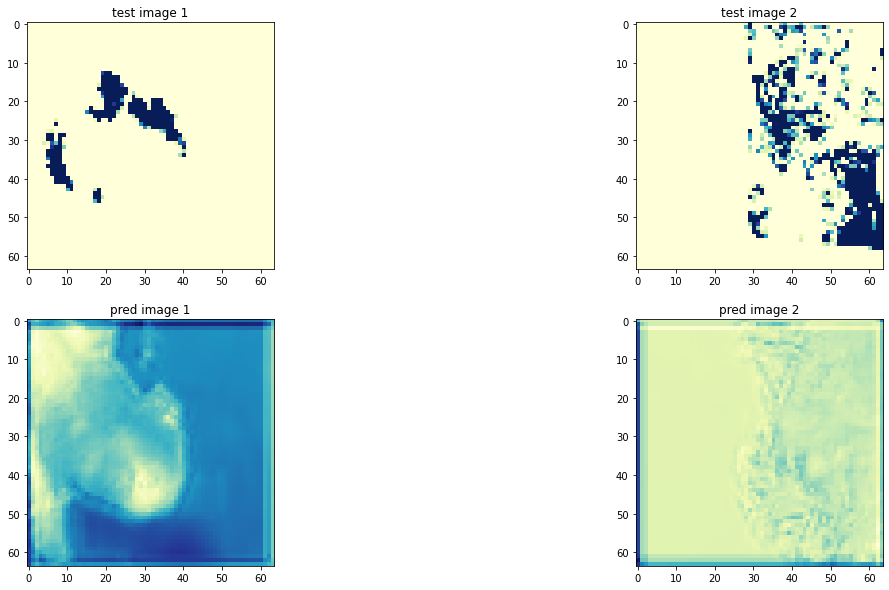

In [522]:
fig, ax = plt.subplots(2, len(y_test), figsize=(20, 10))

for i, im in enumerate(y_test):
    pos = ax[0, i].imshow(im, cmap="YlGnBu", vmin=0, vmax=0.1)
    ax[0, i].set_title(f"test image {i+1}")
    
for i, im in enumerate(y_test):
    pos = ax[0, i].imshow(im, cmap="YlGnBu", vmin=0, vmax=0.1)
    ax[0, i].set_title(f"test image {i+1}")
    
for i, _ in enumerate(y_test):
    ax[1, i].imshow(y_pred[i, :, :, 0], cmap="YlGnBu")
    ax[1, i].set_title(f"pred image {i+1}")

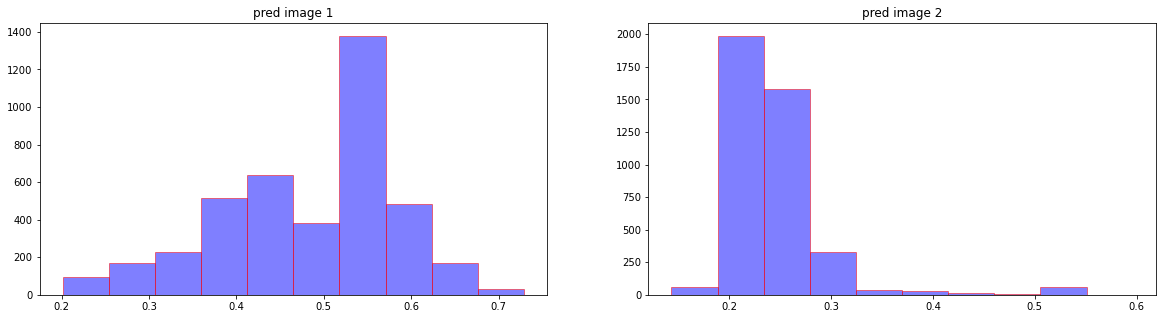

In [523]:
fig, ax = plt.subplots(1, len(y_test), figsize=(20, 5))

for i, _ in enumerate(y_test):
    ax[i].hist(y_pred[i, :, :, 0].flatten(), alpha=0.5, edgecolor="red", color="blue")
    ax[i].set_title(f"pred image {i+1}")

### U-Net

In [524]:
# define the U-Net architecture (from Tutorial)
def double_conv_block(x, depth):
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

def downsample_block(x, depth):
    f = double_conv_block(x, depth)
    p = MaxPooling2D(2)(f)
    p = Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, depth):
    x = Conv2DTranspose(depth, 3, 2, padding="same")(x)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, depth)
    return x

# compile model using the functional API
def build_unet(shape=(128, 128, 3)):
    inputs = Input(shape=shape)
    normalized = BatchNormalization(axis=3)(inputs)
    
    # encoder
    f1, p1 = downsample_block(normalized, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    
    # bottleneck
    bottleneck = double_conv_block(p4, 1024)
    
    # decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    
    # outputs
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(u9)
    unet = Model(inputs, outputs, name="U-Net")
    return unet

In [525]:
unet = build_unet(shape=(64, 64, len(gdf[features].columns)))
unet.compile(optimizer=SGD(learning_rate=1e-6), loss=Tweedie(1.5), metrics="RootMeanSquaredError")
history = unet.fit(train, epochs=40, validation_data=valid, callbacks=EarlyStopping(patience=3))

!say done

Epoch 1/40
20/20 [==============================] - 6s 257ms/step - loss: 0.8651 - root_mean_squared_error: 0.1904 - val_loss: 32.7556 - val_root_mean_squared_error: 0.0760
Epoch 2/40
20/20 [==============================] - 5s 254ms/step - loss: 0.7683 - root_mean_squared_error: 0.1431 - val_loss: 7.5544 - val_root_mean_squared_error: 0.0764
Epoch 3/40
20/20 [==============================] - 5s 237ms/step - loss: 0.7212 - root_mean_squared_error: 0.1323 - val_loss: 2.5072 - val_root_mean_squared_error: 0.0769
Epoch 4/40
20/20 [==============================] - 5s 241ms/step - loss: 0.6974 - root_mean_squared_error: 0.1269 - val_loss: 1.1715 - val_root_mean_squared_error: 0.0775
Epoch 5/40
20/20 [==============================] - 5s 245ms/step - loss: 0.6668 - root_mean_squared_error: 0.1234 - val_loss: 0.7381 - val_root_mean_squared_error: 0.0780
Epoch 6/40
20/20 [==============================] - 5s 230ms/step - loss: 0.6462 - root_mean_squared_error: 0.1208 - val_loss: 0.5840 - val

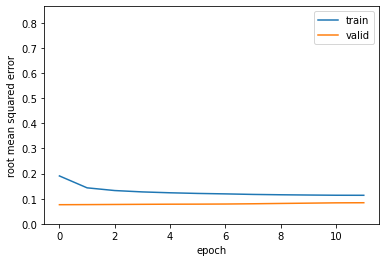

In [526]:
plot_history(history)

Testing set root mean squared error: 0.19


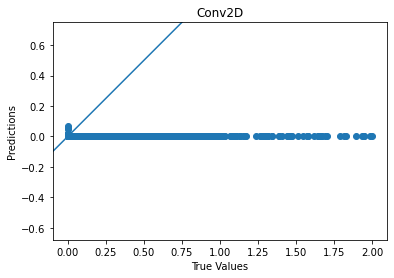

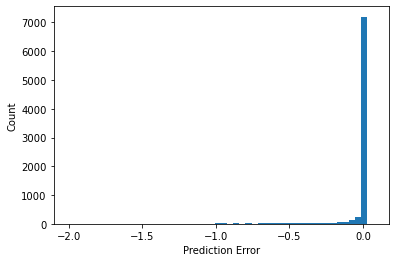

In [527]:
[loss, rmse] = unet.evaluate(test, verbose=0)
print("Testing set root mean squared error: {:4.2f}".format(rmse))

y_pred = unet.predict(test)
plot_prediction(np.array(y_test).flatten(), y_pred.flatten(), "Conv2D")

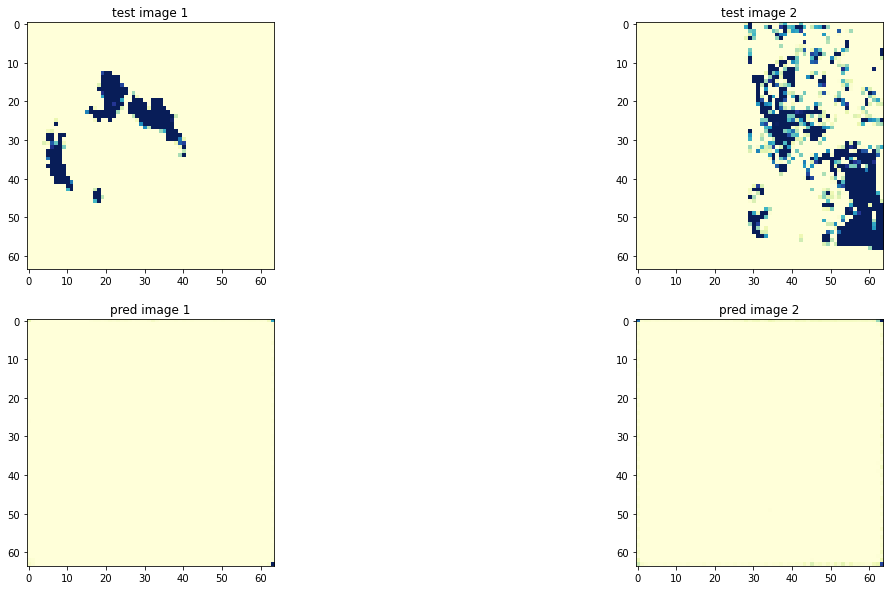

In [528]:
fig, ax = plt.subplots(2, len(y_test), figsize=(20, 10))

for i, im in enumerate(y_test):
    pos = ax[0, i].imshow(im, cmap="YlGnBu", vmin=0, vmax=0.1)
    ax[0, i].set_title(f"test image {i+1}")
    
for i, _ in enumerate(y_test):
    ax[1, i].imshow(y_pred[i, :, :, 0], cmap="YlGnBu")
    ax[1, i].set_title(f"pred image {i+1}")


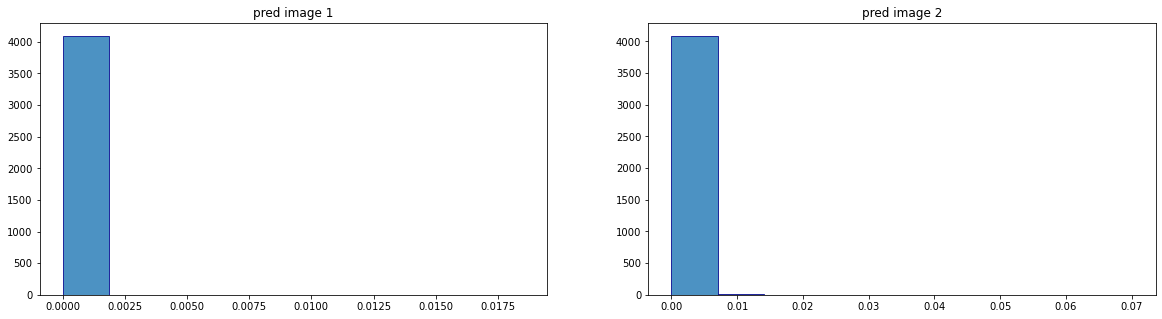

In [529]:
fig, ax = plt.subplots(1, len(y_test), figsize=(20, 5))

for i, _ in enumerate(y_test):
    ax[i].hist(y_pred[i, :, :, 0].flatten(), alpha=0.8, edgecolor="darkblue")
    ax[i].set_title(f"pred image {i+1}")